# Profiling NYC Collisions Data 


### Key Questions
- What fields are there and are they useful? 
- Are the fields missing data?
- Are there significant gaps in the data over time?
- Are there inconsistencies in the total number of people injured or killed and their respective breakdowns into motorist, pedestrian, and cyclist?
- Are many collisions missing location data? 
- Does 'location' match 'latititude' and 'longitude'?
- Are collision locations near NYC? 

### Data Sources
- Collision data obtained from https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95
 

In [1]:
from datetime import datetime
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pandahelper as ph
import scipy.stats
from src import visualizations as viz
from src.constants import (
    NYC_WEST_LIMIT,
    NYC_EAST_LIMIT,
    NYC_SOUTH_LIMIT,
    NYC_NORTH_LIMIT,
)

In [2]:
DATA_LOC = "data/raw/collisions/Collisions.csv"

In [3]:
data = pd.read_csv(
    DATA_LOC,
    dtype={"ZIP CODE": "object"},
    low_memory=False,
)  # read_csv interprets zip code as mixed type

# Overview of DataFrame

In [4]:
ph.DataFrameProfile(data)

DataFrame-Level Info
----------------------  -------------
DF Shape                (2093912, 29)
Duplicated Rows         0
Memory Usage (MB)       2,047.936

Series Name                    Data Type      Memory Usage (MB)
-----------------------------  -----------  -------------------
Index                          int64                   0.000132
CRASH DATE                     object                123.541
CRASH TIME                     object                112.52
BOROUGH                        object                102.276
ZIP CODE                       object                 98.732
LATITUDE                       float64                16.7513
LONGITUDE                      float64                16.7513
LOCATION                       object                140.938
ON STREET NAME                 object                143.656
CROSS STREET NAME              object                118.537
OFF STREET NAME                object                 85.6793
NUMBER OF PERSONS INJURED      float64                16.7513
NUMBER OF PERSONS KILLED       float64                16.7513
NUMBER OF PEDESTRIANS INJURED  int64                  16.7513
NUMBER OF PEDESTRIANS KILLED   int64                  16.7513
NUMBER OF CYCLIST INJURED      int64                  16.7513
NUMBER OF CYCLIST KILLED       int64                  16.7513
NUMBER OF MOTORIST INJURED     int64                  16.7513
NUMBER OF MOTORIST KILLED      int64                  16.7513
CONTRIBUTING FACTOR VEHICLE 1  object                143.222
CONTRIBUTING FACTOR VEHICLE 2  object                120.132
CONTRIBUTING FACTOR VEHICLE 3  object                 71.3014
CONTRIBUTING FACTOR VEHICLE 4  object                 67.9711
CONTRIBUTING FACTOR VEHICLE 5  object                 67.267
COLLISION_ID                   int64                  16.7513
VEHICLE TYPE CODE 1            object                137.473
VEHICLE TYPE CODE 2            object                122.944
VEHICLE TYPE CODE 3            object                 72.0132
VEHICLE TYPE CODE 4            object                 68.1495
VEHICLE TYPE CODE 5            object                 67.319

Summary of Nulls Per Row
--------------------------  ---------
Number of Columns           29
min                          1
1%                           4
5%                           7
25%                          7
50%                          8
75%                         10
95%                         12
99%                         14
max                         18
mean                         8.55919
standard deviation           2.10974
median                       8
median absolute deviation    1
skew                         0.610835

# Examining individual fields (columns)

In [5]:
collision_id_report = ph.SeriesProfile(data["COLLISION_ID"])
collision_id_report

COLLISION_ID Info
-------------------  -------
Data Type            int64
Count                2093912
Unique Values        2093912
Null Values          0

  Value    Count  % of total
-------  -------  ------------
4455765        1  0.00%
4486284        1  0.00%
4486609        1  0.00%
4407458        1  0.00%
4486555        1  0.00%
4486660        1  0.00%
4487074        1  0.00%
4486519        1  0.00%
4486934        1  0.00%
4487127        1  0.00%
4730356        1  0.00%
4730647        1  0.00%
4730503        1  0.00%
4729994        1  0.00%
4730198        1  0.00%

Statistic                             Value
-------------------------  ----------------
count                           2.09391e+06
min                            22
1%                          21086.1
5%                         105550
25%                             3.1596e+06
50%                             3.6832e+06
75%                             4.20692e+06
95%                             4.62578e+06
99%                             4.70954e+06
max                             4.73068e+06
mean                            3.17341e+06
standard deviation              1.50559e+06
median                          3.6832e+06
median absolute deviation  523663
skew                           -1.22937

Collision_ID is the primary key according to the dataset dictionary. We confirm that all its values are unique.

In [6]:
time_report = ph.SeriesProfile(data["CRASH TIME"])
time_report

CRASH TIME Info
-----------------  -------
Data Type          object
Count              2093912
Unique Values      1440
Null Values        0

Value      Count  % of total
-------  -------  ------------
16:00      28567  1.36%
17:00      28053  1.34%
15:00      28019  1.34%
18:00      25920  1.24%
14:00      25677  1.23%
13:00      23875  1.14%
9:00       21700  1.04%
12:00      21584  1.03%
19:00      21566  1.03%
0:00       21044  1.01%
3:41         105  0.01%
3:31         101  0.00%
3:59         101  0.00%
2:31          99  0.00%
4:31          95  0.00%

In [7]:
date_report = ph.SeriesProfile(data["CRASH DATE"])
date_report

CRASH DATE Info
-----------------  -------
Data Type          object
Count              2093912
Unique Values      4357
Null Values        0

Value         Count  % of total
----------  -------  ------------
01/21/2014     1161  0.06%
11/15/2018     1065  0.05%
12/15/2017      999  0.05%
05/19/2017      974  0.05%
01/18/2015      961  0.05%
02/03/2014      960  0.05%
03/06/2015      939  0.04%
05/18/2017      911  0.04%
01/07/2017      896  0.04%
03/02/2018      884  0.04%
04/23/2020      108  0.01%
04/12/2020      106  0.01%
04/09/2020      103  0.00%
04/19/2020      102  0.00%
04/05/2020       94  0.00%

#### __There are no obvious issues with the time and  date info__
- There are no null values in CRASH TIME and CRASH DATE
- All 1440 minutes in a day are represented in time data
- Times tend to be rounded estimates. For example: 16:00 is more common that 4:31, which is unsurprising
- ~3800 unique dates correspond to ~11+ years of data (which is what we have)

In [8]:
loc_report = ph.SeriesProfile(data["LOCATION"])
loc_report

LOCATION Info
---------------  -------
Data Type        object
Count            1859026
Unique Values    285842
Null Values      234886

Value                        Count  % of total
-------------------------  -------  ------------
(0.0, 0.0)                    4432  0.24%
(40.861862, -73.91282)         685  0.04%
(40.608757, -74.038086)        670  0.04%
(40.696033, -73.98453)         646  0.03%
(40.8047, -73.91243)           597  0.03%
(40.6960346, -73.9845292)      587  0.03%
(40.675735, -73.89686)         563  0.03%
(40.658577, -73.89063)         513  0.03%
(40.7606005, -73.9643142)      474  0.03%
(40.820305, -73.89083)         467  0.03%
(40.6097888, -73.9916623)        1  0.00%
(40.653835, -73.95952)           1  0.00%
(40.7896857, -73.9544505)        1  0.00%
(40.8978, -73.839676)            1  0.00%
(40.76764, -73.74379)            1  0.00%

In [9]:
lat_report = ph.SeriesProfile(data["LATITUDE"])
lat_report

LATITUDE Info
---------------  -------
Data Type        float64
Count            1859026
Unique Values    126836
Null Values      234886

  Value    Count  % of total
-------  -------  ------------
 0          4432  0.24%
40.8619      895  0.05%
40.696       773  0.04%
40.8047      692  0.04%
40.6088      671  0.04%
40.7983      627  0.03%
40.7593      625  0.03%
40.696       587  0.03%
40.6757      564  0.03%
40.6586      525  0.03%
40.5799        1  0.00%
40.5872        1  0.00%
40.654         1  0.00%
40.6133        1  0.00%
40.794         1  0.00%

Statistic                          Value
-------------------------  -------------
count                        1.85903e+06
min                          0
1%                          40.5511
5%                          40.5966
25%                         40.6677
50%                         40.7207
75%                         40.7696
95%                         40.862
99%                         40.8887
max                         43.3444
mean                        40.627
standard deviation           1.98764
median                      40.7207
median absolute deviation    0.0513199
skew                       -20.3581

In [10]:
long_report = ph.SeriesProfile(data["LONGITUDE"])
long_report

LONGITUDE Info
----------------  -------
Data Type         float64
Count             1859026
Unique Values     98511
Null Values       234886

   Value    Count  % of total
--------  -------  ------------
  0          4432  0.24%
-73.8906      771  0.04%
-73.9128      719  0.04%
-73.9845      701  0.04%
-74.0381      672  0.04%
-73.8969      664  0.04%
-73.9124      654  0.04%
-73.9448      596  0.03%
-73.9845      587  0.03%
-73.9112      585  0.03%
-73.9604        1  0.00%
-73.8186        1  0.00%
-73.9635        1  0.00%
-74.2115        1  0.00%
-74.0162        1  0.00%

Statistic                           Value
-------------------------  --------------
count                         1.85903e+06
min                        -201.36
1%                          -74.168
5%                          -74.0364
25%                         -73.9748
50%                         -73.9272
75%                         -73.8667
95%                         -73.7632
99%                         -73.7283
max                           0
mean                        -73.7508
standard deviation            3.73441
median                      -73.9272
median absolute deviation     0.0526032
skew                         16.1063

In [11]:
percent_missing_loc = sum(data["LOCATION"].isna()) / len(data)
percent_missing_loc

0.11217567882508911

__~11.2% of collisions are missing location data__
- LOCATION is just the tuple, (LATITUDE, LONGITUDE)
- Some lat-long coordinates are invalid. For example: (0, 0) or a latitiude of 43.3444 (max latitude), which is far from NYC

In [12]:
injured_report = ph.SeriesProfile(data["NUMBER OF PERSONS INJURED"])
injured_report

NUMBER OF PERSONS INJURED Info
--------------------------------  -------
Data Type                         float64
Count                             2093894
Unique Values                     32
Null Values                       18

  Value    Count  % of total
-------  -------  ------------
      0  1611736  76.97%
      1   374201  17.87%
      2    70505  3.37%
      3    23037  1.10%
      4     8536  0.41%
      5     3272  0.16%
      6     1374  0.07%
      7      581  0.03%
      8      261  0.01%
      9      131  0.01%
     31        1  0.00%
     32        1  0.00%
     27        1  0.00%
     40        1  0.00%
     25        1  0.00%

Statistic                         Value
-------------------------  ------------
count                       2.09389e+06
min                         0
1%                          0
5%                          0
25%                         0
50%                         0
75%                         0
95%                         2
99%                         3
max                        43
mean                        0.312226
standard deviation          0.702075
median                      0
median absolute deviation   0
skew                        4.23576

In [13]:
pedestrian_injured_report = ph.SeriesProfile(data["NUMBER OF PEDESTRIANS INJURED"])
pedestrian_injured_report

NUMBER OF PEDESTRIANS INJURED Info
------------------------------------  -------
Data Type                             int64
Count                                 2093912
Unique Values                         14
Null Values                           0

  Value    Count  % of total
-------  -------  ------------
      0  1979735  94.55%
      1   109996  5.25%
      2     3702  0.18%
      3      369  0.02%
      4       61  0.00%
      5       26  0.00%
      6       11  0.00%
      7        4  0.00%
      9        2  0.00%
      8        2  0.00%
     27        1  0.00%
     13        1  0.00%
     15        1  0.00%
     19        1  0.00%

Statistic                         Value
-------------------------  ------------
count                       2.09391e+06
min                         0
1%                          0
5%                          0
25%                         0
50%                         0
75%                         0
95%                         1
99%                         1
max                        27
mean                        0.0568711
standard deviation          0.244666
median                      0
median absolute deviation   0
skew                        5.651

In [14]:
cyclist_injured_report = ph.SeriesProfile(data["NUMBER OF CYCLIST INJURED"])
cyclist_injured_report

NUMBER OF CYCLIST INJURED Info
--------------------------------  -------
Data Type                         int64
Count                             2093912
Unique Values                     5
Null Values                       0

  Value    Count  % of total
-------  -------  ------------
      0  2037940  97.33%
      1    55328  2.64%
      2      619  0.03%
      3       24  0.00%
      4        1  0.00%

Statistic                        Value
-------------------------  -----------
count                      2.09391e+06
min                        0
1%                         0
5%                         0
25%                        0
50%                        0
75%                        0
95%                        0
99%                        1
max                        4
mean                       0.0270508
standard deviation         0.164271
median                     0
median absolute deviation  0
skew                       6.07259

In [15]:
motorist_injured_report = ph.SeriesProfile(data["NUMBER OF MOTORIST INJURED"])
motorist_injured_report

NUMBER OF MOTORIST INJURED Info
---------------------------------  -------
Data Type                          int64
Count                              2093912
Unique Values                      31
Null Values                        0

  Value    Count  % of total
-------  -------  ------------
      0  1786399  85.31%
      1   206767  9.87%
      2    64316  3.07%
      3    22341  1.07%
      4     8359  0.40%
      5     3220  0.15%
      6     1327  0.06%
      7      555  0.03%
      8      253  0.01%
      9      126  0.01%
     30        1  0.00%
     43        1  0.00%
     23        1  0.00%
     34        1  0.00%
     25        1  0.00%

Statistic                         Value
-------------------------  ------------
count                       2.09391e+06
min                         0
1%                          0
5%                          0
25%                         0
50%                         0
75%                         0
95%                         1
99%                         3
max                        43
mean                        0.224536
standard deviation          0.663279
median                      0
median absolute deviation   0
skew                        5.09775

__A few observations (< 50) are missing the the total number of people injured.__

There are no missing values for the individual pedestrian, cyclist, and motorist injured fields

In [16]:
killed_report = ph.SeriesProfile(data["NUMBER OF PERSONS KILLED"])
killed_report

NUMBER OF PERSONS KILLED Info
-------------------------------  -------
Data Type                        float64
Count                            2093881
Unique Values                    7
Null Values                      31

  Value    Count  % of total
-------  -------  ------------
      0  2090855  99.86%
      1     2932  0.14%
      2       76  0.00%
      3       12  0.00%
      4        3  0.00%
      5        2  0.00%
      8        1  0.00%

Statistic                         Value
-------------------------  ------------
count                       2.09388e+06
min                         0
1%                          0
5%                          0
25%                         0
50%                         0
75%                         0
95%                         0
99%                         0
max                         8
mean                        0.00150438
standard deviation          0.0408918
median                      0
median absolute deviation   0
skew                       33.5412

In [17]:
pedestrian_killed_report = ph.SeriesProfile(data["NUMBER OF PEDESTRIANS KILLED"])
pedestrian_killed_report

NUMBER OF PEDESTRIANS KILLED Info
-----------------------------------  -------
Data Type                            int64
Count                                2093912
Unique Values                        4
Null Values                          0

  Value    Count  % of total
-------  -------  ------------
      0  2092368  99.93%
      1     1531  0.07%
      2       12  0.00%
      6        1  0.00%

Statistic                         Value
-------------------------  ------------
count                       2.09391e+06
min                         0
1%                          0
5%                          0
25%                         0
50%                         0
75%                         0
95%                         0
99%                         0
max                         6
mean                        0.000745495
standard deviation          0.027762
median                      0
median absolute deviation   0
skew                       41.0548

In [18]:
cyclist_killed_report = ph.SeriesProfile(data["NUMBER OF CYCLIST KILLED"])
cyclist_killed_report

NUMBER OF CYCLIST KILLED Info
-------------------------------  -------
Data Type                        int64
Count                            2093912
Unique Values                    3
Null Values                      0

  Value    Count  % of total
-------  -------  ------------
      0  2093669  99.99%
      1      242  0.01%
      2        1  0.00%

Statistic                         Value
-------------------------  ------------
count                       2.09391e+06
min                         0
1%                          0
5%                          0
25%                         0
50%                         0
75%                         0
95%                         0
99%                         0
max                         2
mean                        0.000116528
standard deviation          0.0108384
median                      0
median absolute deviation   0
skew                       93.7438

In [19]:
motorist_killed_report = ph.SeriesProfile(data["NUMBER OF MOTORIST KILLED"])
motorist_killed_report

NUMBER OF MOTORIST KILLED Info
--------------------------------  -------
Data Type                         int64
Count                             2093912
Unique Values                     6
Null Values                       0

  Value    Count  % of total
-------  -------  ------------
      0  2092714  99.94%
      1     1122  0.05%
      2       60  0.00%
      3       12  0.00%
      4        2  0.00%
      5        2  0.00%

Statistic                         Value
-------------------------  ------------
count                       2.09391e+06
min                         0
1%                          0
5%                          0
25%                         0
50%                         0
75%                         0
95%                         0
99%                         0
max                         5
mean                        0.000618937
standard deviation          0.0272179
median                      0
median absolute deviation   0
skew                       54.5027

__A few observations (< 50) are missing the the total number of people killed.__

There are no missing values for the individual pedestrian, cyclist, and motorist killed fields

In [20]:
factor1_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 1"])
factor1_report

CONTRIBUTING FACTOR VEHICLE 1 Info
------------------------------------  -------
Data Type                             object
Count                                 2086982
Unique Values                         61
Null Values                           6930

Value                             Count  % of total
------------------------------  -------  ------------
Unspecified                      711277  34.08%
Driver Inattention/Distraction   419758  20.11%
Failure to Yield Right-of-Way    124543  5.97%
Following Too Closely            112135  5.37%
Backing Unsafely                  77300  3.70%
Other Vehicular                   64993  3.11%
Passing or Lane Usage Improper    58604  2.81%
Passing Too Closely               52230  2.50%
Turning Improperly                51692  2.48%
Fatigued/Drowsy                   47422  2.27%
Windshield Inadequate                81  0.00%
Cell Phone (hand-held)               79  0.00%
Texting                              53  0.00%
Listening/Using Headphones           26  0.00%
1                                    10  0.00%

In [21]:
factor2_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 2"])
factor2_report

CONTRIBUTING FACTOR VEHICLE 2 Info
------------------------------------  -------
Data Type                             object
Count                                 1767970
Unique Values                         61
Null Values                           325942

Value                             Count  % of total
------------------------------  -------  ------------
Unspecified                     1488536  84.19%
Driver Inattention/Distraction    95035  5.38%
Other Vehicular                   32295  1.83%
Following Too Closely             19243  1.09%
Failure to Yield Right-of-Way     17248  0.98%
Passing or Lane Usage Improper    12978  0.73%
Fatigued/Drowsy                   10837  0.61%
Passing Too Closely                8785  0.50%
Turning Improperly                 8777  0.50%
Backing Unsafely                   7927  0.45%
Eating or Drinking                   12  0.00%
Listening/Using Headphones           11  0.00%
Windshield Inadequate                 7  0.00%
1                                     5  0.00%
Texting                               3  0.00%

In [22]:
factor3_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 3"])
factor3_report

CONTRIBUTING FACTOR VEHICLE 3 Info
------------------------------------  -------
Data Type                             object
Count                                 149913
Unique Values                         51
Null Values                           1943999

Value                                   Count  % of total
------------------------------------  -------  ------------
Unspecified                            139739  93.21%
Other Vehicular                          2819  1.88%
Following Too Closely                    1986  1.32%
Driver Inattention/Distraction           1982  1.32%
Fatigued/Drowsy                           853  0.57%
Pavement Slippery                         399  0.27%
Reaction to Uninvolved Vehicle            213  0.14%
Driver Inexperience                       183  0.12%
Unsafe Speed                              165  0.11%
Outside Car Distraction                   163  0.11%
Reaction to Other Uninvolved Vehicle        2  0.00%
Eating or Drinking                          1  0.00%
Cell Phone (hand-Held)                      1  0.00%
1                                           1  0.00%
Illnes                                      1  0.00%

In [23]:
factor4_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 4"])
factor4_report

CONTRIBUTING FACTOR VEHICLE 4 Info
------------------------------------  -------
Data Type                             object
Count                                 33904
Unique Values                         42
Null Values                           2060008

Value                             Count  % of total
------------------------------  -------  ------------
Unspecified                       31978  94.32%
Other Vehicular                     628  1.85%
Following Too Closely               393  1.16%
Driver Inattention/Distraction      280  0.83%
Fatigued/Drowsy                     170  0.50%
Pavement Slippery                   119  0.35%
Reaction to Uninvolved Vehicle       42  0.12%
Unsafe Speed                         33  0.10%
Outside Car Distraction              29  0.09%
Driver Inexperience                  27  0.08%
Animals Action                        1  0.00%
Windshield Inadequate                 1  0.00%
Tire Failure/Inadequate               1  0.00%
Oversized Vehicle                     1  0.00%
Passenger Distraction                 1  0.00%

In [24]:
factor5_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 5"])
factor5_report

CONTRIBUTING FACTOR VEHICLE 5 Info
------------------------------------  -------
Data Type                             object
Count                                 9196
Unique Values                         30
Null Values                           2084716

Value                             Count  % of total
------------------------------  -------  ------------
Unspecified                        8669  94.27%
Other Vehicular                     182  1.98%
Following Too Closely                99  1.08%
Driver Inattention/Distraction       65  0.71%
Pavement Slippery                    50  0.54%
Fatigued/Drowsy                      41  0.45%
Reaction to Uninvolved Vehicle       12  0.13%
Alcohol Involvement                  11  0.12%
Driver Inexperience                  10  0.11%
Obstruction/Debris                   10  0.11%
Illness                               1  0.01%
Passing or Lane Usage Improper        1  0.01%
Aggressive Driving/Road Rage          1  0.01%
Pavement Defective                    1  0.01%
Oversized Vehicle                     1  0.01%

__The 'CONTRIBUTING FACTOR VEHICLE' fields seem to have some issues__
- "Unspecified" is the most common response
- They are not mutually exclusive and in some cases, difficult to differentiate. For example: 'Passing or Lane Usage Improper' vs 'Passing Too Closely'
- Without knowing more about the processes that generated these _'contributing factor'_ fields, it would be difficult to use them with confidence

In [25]:
vtype1_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 1"])
vtype1_report

VEHICLE TYPE CODE 1 Info
--------------------------  -------
Data Type                   object
Count                       2079921
Unique Values               1671
Null Values                 13991

Value                                  Count  % of total
-----------------------------------  -------  ------------
Sedan                                 584855  28.12%
Station Wagon/Sport Utility Vehicle   459960  22.11%
PASSENGER VEHICLE                     416206  20.01%
SPORT UTILITY / STATION WAGON         180291  8.67%
Taxi                                   52057  2.50%
4 dr sedan                             40179  1.93%
Pick-up Truck                          35147  1.69%
TAXI                                   31911  1.53%
VAN                                    25266  1.21%
Box Truck                              24603  1.18%
LSA                                        1  0.00%
FLED                                       1  0.00%
TLC P                                      1  0.00%
vAN                                        1  0.00%
COT                                        1  0.00%

In [26]:
vtype2_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 2"])
vtype2_report

VEHICLE TYPE CODE 2 Info
--------------------------  -------
Data Type                   object
Count                       1691225
Unique Values               1849
Null Values                 402687

Value                                  Count  % of total
-----------------------------------  -------  ------------
Sedan                                 408420  24.15%
Station Wagon/Sport Utility Vehicle   330362  19.53%
PASSENGER VEHICLE                     318607  18.84%
SPORT UTILITY / STATION WAGON         140204  8.29%
UNKNOWN                                81509  4.82%
Taxi                                   37530  2.22%
Bike                                   32446  1.92%
Pick-up Truck                          31740  1.88%
4 dr sedan                             30084  1.78%
Box Truck                              28475  1.68%
OMNI                                       1  0.00%
OMNIB                                      1  0.00%
tilla                                      1  0.00%
MAC F                                      1  0.00%
Dodge                                      1  0.00%

In [27]:
vtype3_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 3"])
vtype3_report

VEHICLE TYPE CODE 3 Info
--------------------------  -------
Data Type                   object
Count                       144412
Unique Values               265
Null Values                 1949500

Value                                  Count  % of total
-----------------------------------  -------  ------------
Sedan                                  45129  31.25%
Station Wagon/Sport Utility Vehicle    36714  25.42%
PASSENGER VEHICLE                      27713  19.19%
SPORT UTILITY / STATION WAGON          13358  9.25%
UNKNOWN                                 3284  2.27%
4 dr sedan                              2564  1.78%
Pick-up Truck                           2355  1.63%
Taxi                                    2243  1.55%
VAN                                     1366  0.95%
OTHER                                   1045  0.72%
POLICE VEH                                 1  0.00%
DELV                                       1  0.00%
MINIVAN                                    1  0.00%
Ford                                       1  0.00%
PICK-UP TR                                 1  0.00%

In [28]:
vtype4_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 4"])
vtype4_report

VEHICLE TYPE CODE 4 Info
--------------------------  -------
Data Type                   object
Count                       32721
Unique Values               103
Null Values                 2061191

Value                                  Count  % of total
-----------------------------------  -------  ------------
Sedan                                  10996  33.61%
Station Wagon/Sport Utility Vehicle     9034  27.61%
PASSENGER VEHICLE                       5969  18.24%
SPORT UTILITY / STATION WAGON           2852  8.72%
UNKNOWN                                  595  1.82%
4 dr sedan                               568  1.74%
Pick-up Truck                            496  1.52%
Taxi                                     449  1.37%
VAN                                      242  0.74%
OTHER                                    189  0.58%
PICK-UP TR                                 1  0.00%
bus                                        1  0.00%
DELIVERY T                                 1  0.00%
Pedicab                                    1  0.00%
FIRETRUCK                                  1  0.00%

In [29]:
vtype5_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 5"])
vtype5_report

VEHICLE TYPE CODE 5 Info
--------------------------  -------
Data Type                   object
Count                       8915
Unique Values               71
Null Values                 2084997

Value                                  Count  % of total
-----------------------------------  -------  ------------
Sedan                                   3112  34.91%
Station Wagon/Sport Utility Vehicle     2572  28.85%
PASSENGER VEHICLE                       1487  16.68%
SPORT UTILITY / STATION WAGON            802  9.00%
Pick-up Truck                            155  1.74%
4 dr sedan                               123  1.38%
Taxi                                     112  1.26%
UNKNOWN                                   94  1.05%
VAN                                       50  0.56%
OTHER                                     49  0.55%
Lunch Wagon                                1  0.01%
Truck                                      1  0.01%
TRAILER                                    1  0.01%
TRUCK                                      1  0.01%
Soccer                                     1  0.01%

__Vehicle type categories are somewhat unclear__
- "Passenger vehicle" is one of the biggest categories. What does 'passenger vehicle' mean given that there are already categories for sedans and SUVs?

# Are there significant gaps in data collection over time?

Adding a datetime column to make temporal analysis easier

In [30]:
dt_format = "%m/%d/%Y %H:%M"
data["datetime"] = data["CRASH DATE"] + " " + data["CRASH TIME"]
data["datetime"] = data["datetime"].apply(lambda x: datetime.strptime(x, dt_format))

There do not appear to be any extended periods of time without reported collisions.

In [31]:
ph.id_gaps(data["datetime"], threshold=pd.Timedelta(hours=2))

,diffs
datetime,
2020-04-02 04:49:00,0 days 03:59:00
2020-06-18 05:25:00,0 days 03:12:00
2021-04-22 05:45:00,0 days 03:10:00
2020-03-22 04:18:00,0 days 03:00:00
2023-06-06 05:00:00,0 days 03:00:00
2020-04-28 05:51:00,0 days 02:51:00
2024-01-04 05:00:00,0 days 02:45:00
2021-01-06 06:00:00,0 days 02:42:00
2024-04-18 04:30:00,0 days 02:40:00


Examining daily collisions, injuries, and deaths to check to gaps in the data

In [32]:
daily_collisions = data.groupby(by=data["datetime"].dt.date)["COLLISION_ID"].count()
daily_injuries = data.groupby(by=data["datetime"].dt.date)[
    "NUMBER OF PERSONS INJURED"
].sum()
daily_deaths = data.groupby(by=data["datetime"].dt.date)[
    "NUMBER OF PERSONS KILLED"
].sum()

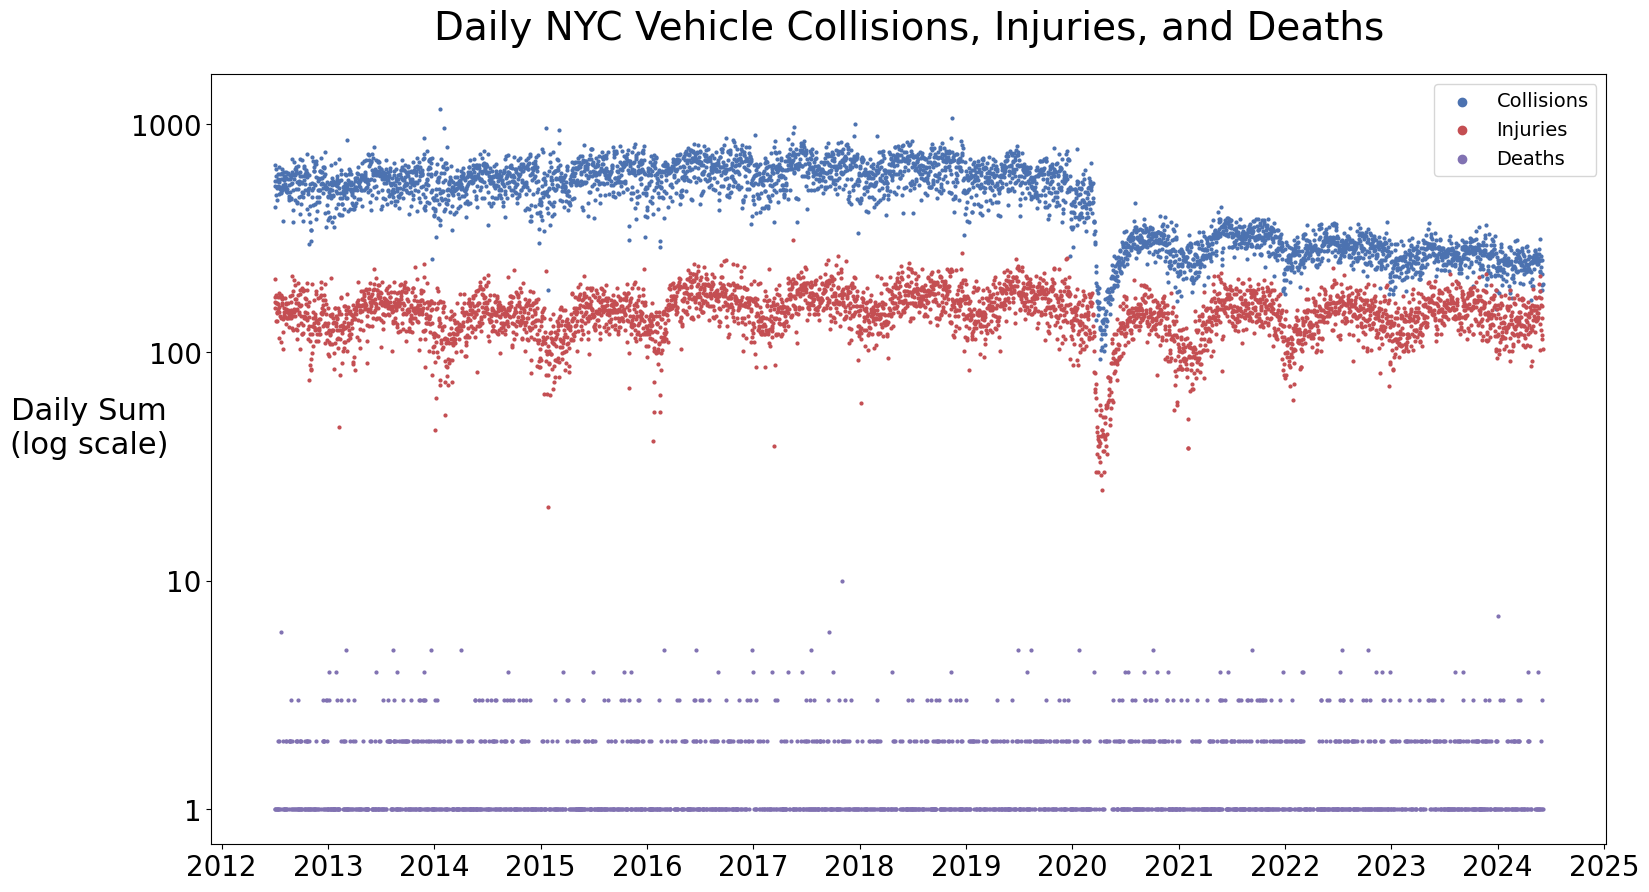

In [33]:
scatter_params = {
    "title": "Daily NYC Vehicle Collisions, Injuries, and Deaths",
    "ylabel": "Daily Sum\n(log scale)",
    "yaxis_format": "{x:.0f}",
    "ylogscale": True,
}
with plt.style.context("default"):
    fig, ax = viz.setup_chart(**scatter_params)
    ax.xaxis.set_major_locator(mpl.dates.YearLocator(1))
    ax.scatter(y=daily_collisions, x=daily_collisions.index, s=4)  # s is marker size
    ax.scatter(y=daily_injuries, x=daily_injuries.index, s=4)
    ax.scatter(y=daily_deaths, x=daily_deaths.index, s=4)
    ax.legend(["Collisions", "Injuries", "Deaths"], fontsize=14, markerscale=3)
    plt.show()

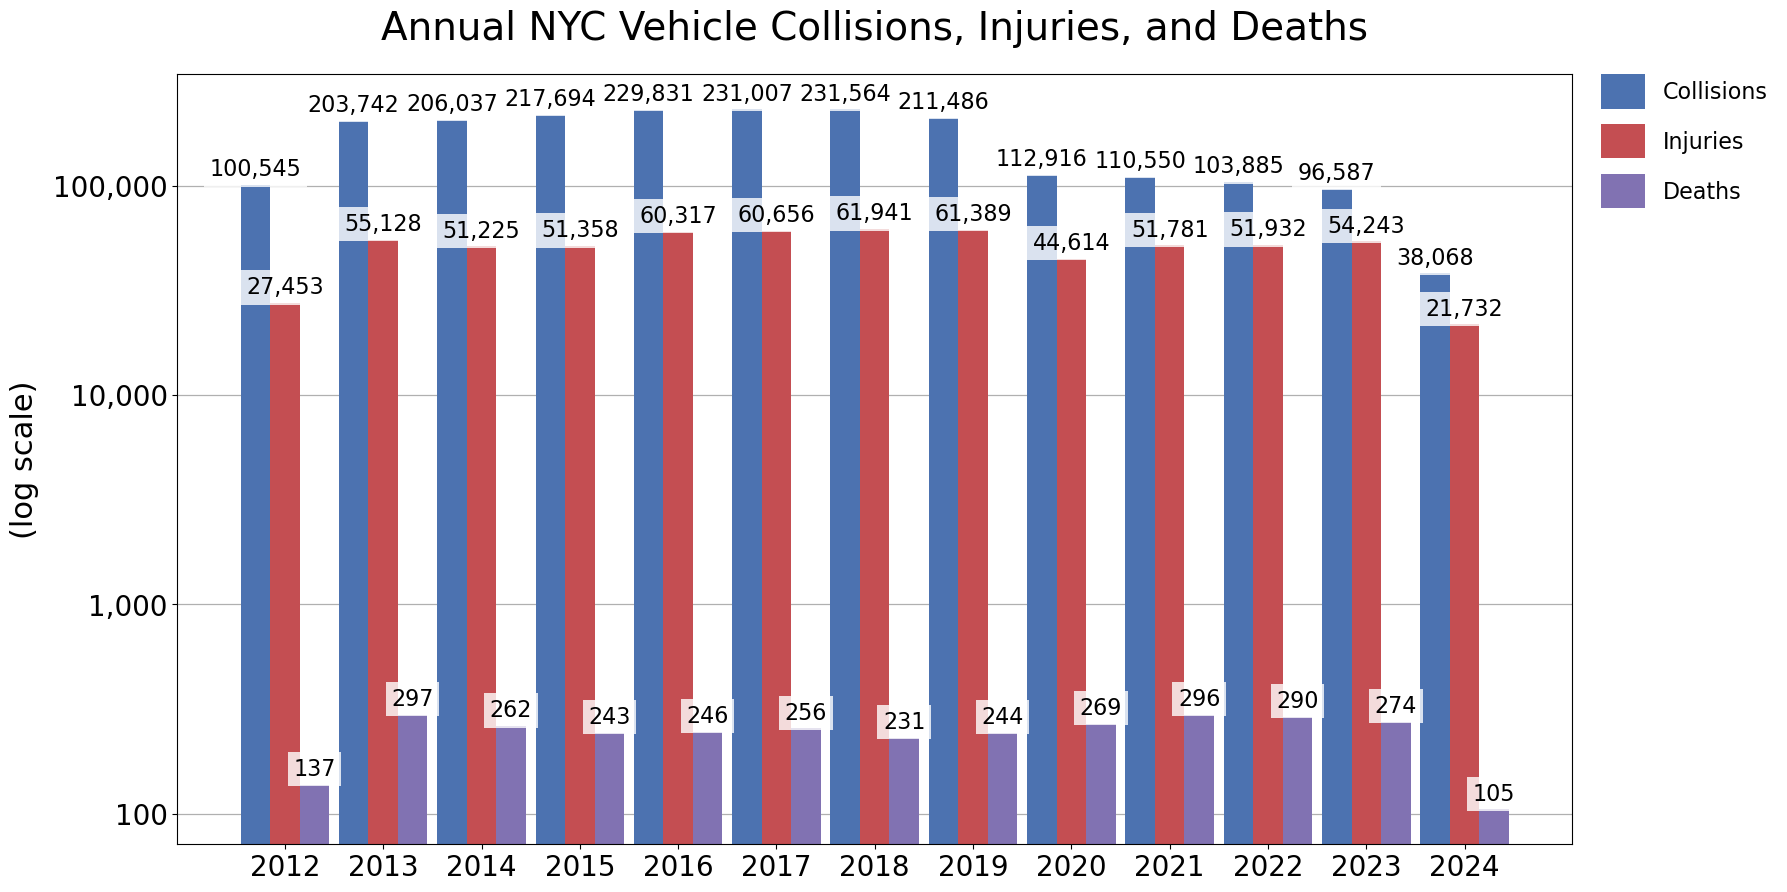

In [34]:
annual = pd.DataFrame()
annual["Collisions"] = data.groupby(by=data["datetime"].dt.year)["COLLISION_ID"].count()
annual["Injured"] = data.groupby(by=data["datetime"].dt.year)[
    "NUMBER OF PERSONS INJURED"
].sum()
annual["Deaths"] = data.groupby(by=data["datetime"].dt.year)[
    "NUMBER OF PERSONS KILLED"
].sum()
viz.grouped_bar_chart(
    annual,
    title="Annual NYC Vehicle Collisions, Injuries, and Deaths",
    ylabel="(log scale)",
    ylabel_rotation="vertical",
    ylabel_pad=10,
    ylogscale=True,
    yaxis_format="{x:,.0f}",
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    legend_labels=["Collisions", "Injuries", "Deaths"],
    legend_args={"legend_bbox": (1.02, 0.9), "legend_handleheight": 2.0},
)

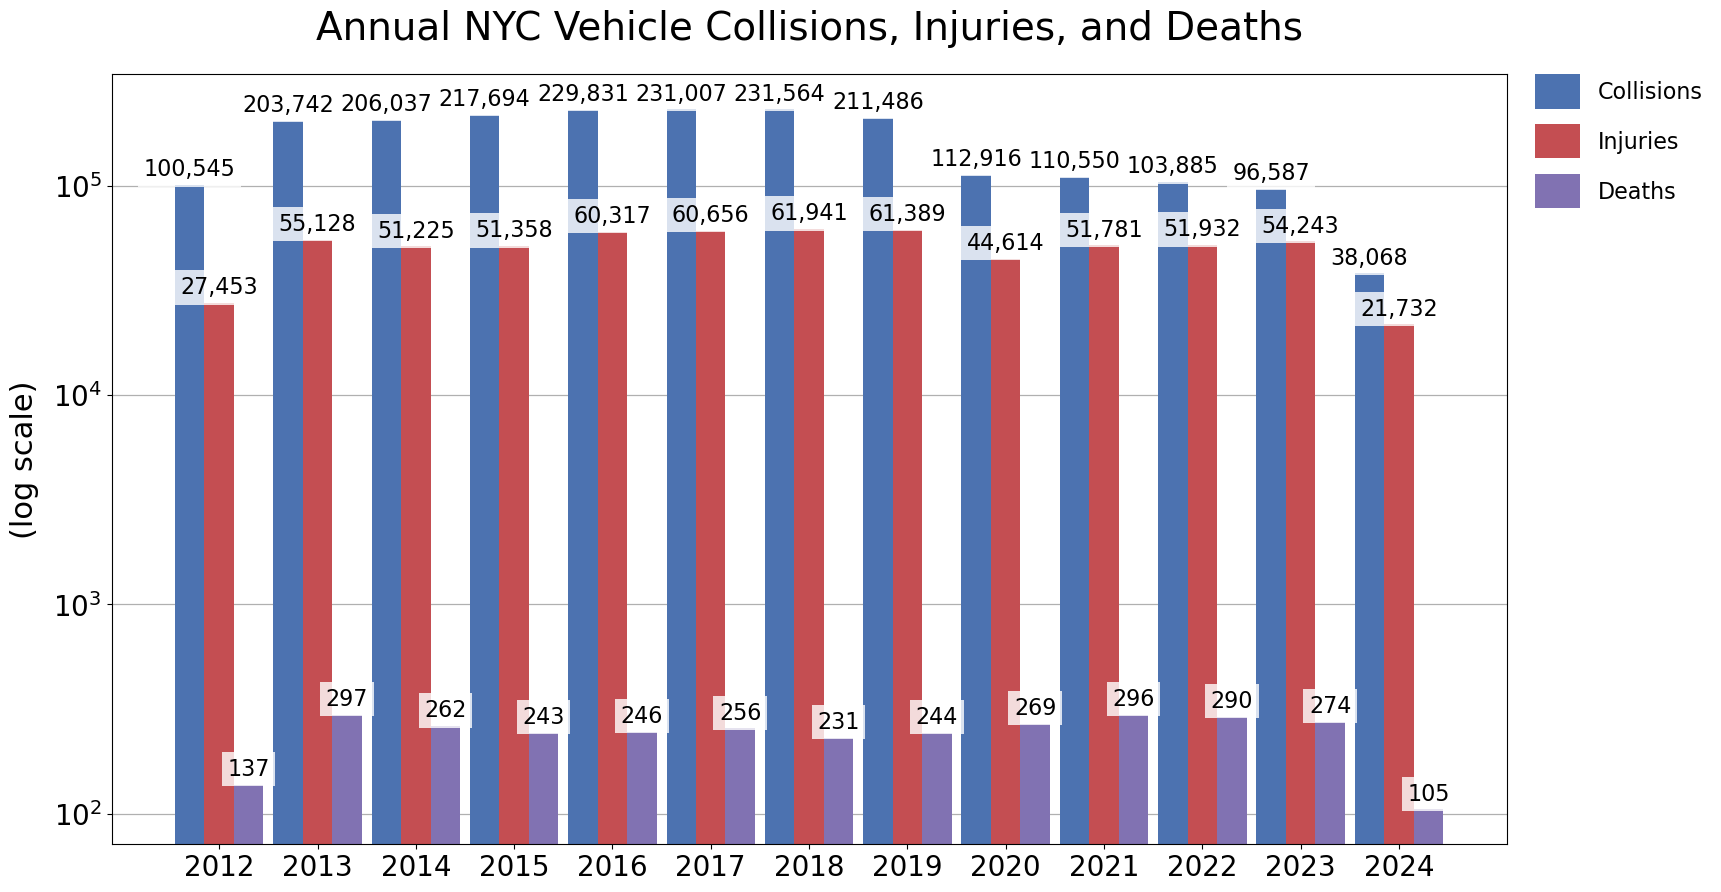

In [35]:
annual = pd.DataFrame()
annual["Collisions"] = data.groupby(by=data["datetime"].dt.year)["COLLISION_ID"].count()
annual["Injured"] = data.groupby(by=data["datetime"].dt.year)[
    "NUMBER OF PERSONS INJURED"
].sum()
annual["Deaths"] = data.groupby(by=data["datetime"].dt.year)[
    "NUMBER OF PERSONS KILLED"
].sum()
viz.grouped_bar_chart(
    annual,
    title="Annual NYC Vehicle Collisions, Injuries, and Deaths",
    ylabel="(log scale)",
    ylabel_rotation="vertical",
    ylabel_pad=10,
    ylogscale=True,
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    legend_labels=["Collisions", "Injuries", "Deaths"],
    legend_args={"legend_bbox": (1.02, 0.9), "legend_handleheight": 2.0},
)

In [36]:
data["datetime"].min(), data["datetime"].max()

(Timestamp('2012-07-01 00:05:00'), Timestamp('2024-06-04 23:58:00'))

__It appears that the dramatic drop in overall collisions (but not injuries and deaths) starting in 2020 may be due to a change in New York Police Department (NYPD) policy where police will no longer respond to collisions without injuries. As a result it is likely that fewer MV104-AN forms are being filled out by motorists and going into the dataset.__

- https://nyc.streetsblog.org/2020/03/30/breaking-nypd-will-no-longer-respond-to-minor-car-crashes
- https://nyc.streetsblog.org/2020/04/03/nypd-gives-a-few-details-of-new-no-report-crash-policy

### __There does not appear to a major gaps in data regarding injuries and deaths going back to the start of the data set (July 2012)__
- __Total collisions numbers after 2018 are unlikely to be accurate or consistent with previous years due to a change in police policy and the data generating process__
- __Fatal collisions are a small percentage of the dataset. Collisions with injuries are more common__
- __Let's limit the scope of analysis to 1 January 2013 to 31 December 2023, a 11 year span__

In [37]:
start = datetime(year=2013, month=1, day=1)
end = datetime(year=2024, month=1, day=1)
crashes = data[data["datetime"].between(start, end, inclusive="left")].copy()
crashes["datetime"].min(), crashes["datetime"].max()

(Timestamp('2013-01-01 00:01:00'), Timestamp('2023-12-31 23:18:00'))

# Does 'NUMBER OF PERSONS INJURED' match the separate 'INJURED' categories?

In [38]:
crashes["sum injured categories"] = (
    crashes["NUMBER OF PEDESTRIANS INJURED"]
    + crashes["NUMBER OF CYCLIST INJURED"]
    + crashes["NUMBER OF MOTORIST INJURED"]
)
num_mismatch = len(
    crashes[crashes["sum injured categories"] != crashes["NUMBER OF PERSONS INJURED"]]
)
num_mismatch

7314

In [39]:
num_mismatch / len(crashes)

0.0037406043781539294

### There do appear to be ~7300 collisions (or < 0.4% of total collisions) where the 'NUMBER OF PERSONS INJURED' field does not match the sum of the distinct injured categories (pedestrian, cyclist, motorist)

In [40]:
total_injured = crashes["NUMBER OF PERSONS INJURED"].sum()
difference = (
    crashes["NUMBER OF PERSONS INJURED"].sum() - crashes["sum injured categories"].sum()
)
difference

7214.0

In [41]:
(difference / total_injured)

0.011932171542746749

- The cumulative discrepancy between the 'NUMBER OF PERSONS INJURED' field and the sum of the distinct injury fields (pedestrian, cyclist, motorist) is ~7200 injuries or < 1.2%
- __Given the relatively small difference, we will use the separate 'injury' fields in our analyses going forward__


# Does 'NUMBER OF PERSONS KILLED' match the separate 'KILLED' categories?

In [42]:
crashes["sum killed categories"] = (
    crashes["NUMBER OF PEDESTRIANS KILLED"]
    + crashes["NUMBER OF CYCLIST KILLED"]
    + crashes["NUMBER OF MOTORIST KILLED"]
)
len(crashes[crashes["sum killed categories"] != crashes["NUMBER OF PERSONS KILLED"]])

91

In [43]:
total_killed = crashes["NUMBER OF PERSONS KILLED"].sum()
difference_deaths = (
    crashes["NUMBER OF PERSONS KILLED"].sum() - crashes["sum killed categories"].sum()
)
difference_deaths

48.0

In [44]:
(difference_deaths / total_killed)

0.016506189821182942

- There are ~90 collisions with differences between the 'NUMBER OF PERSONS KILLED' field and the sum of the separate killed fields (pedestrian, cyclist, motorist). The 48 death discrepancy represents a small percent of the total deaths (< 1.7%)

- __Once again given the relatively small difference, we will use the separate 'killed' fields in our analyses going forward__

# Are many serious collisions missing location information? 

- We define _serious_ as a collision that results in injury or death. 
- Future analyses will tend to focus on serious collisions

In [45]:
crashes["serious_accident"] = (crashes["NUMBER OF PERSONS INJURED"] > 0) | (
    crashes["NUMBER OF PERSONS KILLED"] > 0
)
crashes["lat_long_missing"] = crashes["LOCATION"].isna()

In [46]:
(len(crashes) - crashes["lat_long_missing"].sum()) / len(crashes)

0.8888308130879216

~89% of collisions have lat_long coordinates

In [47]:
pd.crosstab(
    index=crashes["lat_long_missing"],
    columns=crashes["serious_accident"],
    margins=True,
    normalize=True,
)

serious_accident,False,True,All
lat_long_missing,,,
False,0.683194,0.205637,0.888831
True,0.087632,0.023537,0.111169
All,0.770826,0.229174,1.000000


In [48]:
contingency_table = pd.crosstab(
    index=crashes["lat_long_missing"], columns=crashes["serious_accident"]
)
chi2_results = scipy.stats.chi2_contingency(contingency_table)
p_val = chi2_results[1]
p_val

1.152463904854277e-93

In [49]:
contingency_table

serious_accident,False,True
lat_long_missing,,
False,1335848,402082
True,171347,46022


In [50]:
# col, row indexing
percent_with_lat_long_that_are_serious = contingency_table.iloc[0].iloc[1] / (
    contingency_table.iloc[0].iloc[0] + contingency_table.iloc[0].iloc[1]
)

percent_with_lat_long_that_are_serious

0.23135684406161353

In [51]:
percent_missing_lat_long_that_are_serious = contingency_table.iloc[1].iloc[1] / (
    contingency_table.iloc[1].iloc[0] + contingency_table.iloc[1].iloc[1]
)
percent_missing_lat_long_that_are_serious

0.2117229227718764

In [52]:
percent_serious_missing_lat_long = contingency_table.iloc[1].iloc[1] / (
    contingency_table.iloc[0].iloc[1] + contingency_table.iloc[1].iloc[1]
)
percent_serious_missing_lat_long

0.10270383660935854

- The p-value of the Chi-squared test is ~0
- Using the Chi-squared test, we reject the null hypothesis that the percentage of collisions with injuries is the same for the population with lat-longs coordinates as for the population without lat-longs coordinates
- Approximately ~23% of the collisions that have lat-long coordinates are serious (with injuries or deaths)
- Approximately ~21% of the collisions that are missing coordinates are serious
- Serious collisions seem to be more likely to have lat-long coordinates with than less serious collisions
- ___The good news is that an analysis requiring lat-longs will not exclude data with a higher concentration of serious collisions___
- ___The bad news is that ~10% of serious accidents will be removed from the dataset by excluding collisions without lat-long coordinates___

A quick view of some serious accidents that are missing coordinates suggests that a more in-depth analysis could obtain approximate lat-long coordinates for some of the serious accidents based on other location data

In [53]:
serious_missing_location = crashes[
    (crashes["LOCATION"].isna()) & (crashes["serious_accident"])
]
serious_missing_location[
    ["ON STREET NAME", "CROSS STREET NAME", "OFF STREET NAME"]
].head(20)

,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME
0,WHITESTONE EXPRESSWAY,20 AVENUE,NaN
1,QUEENSBORO BRIDGE UPPER,NaN,NaN
17,MEEKER AVENUE,LORIMER STREET,NaN
33,KINGSLAND AVENUE,MEEKER AVENUE,NaN
34,WILLIAMSBURG BRIDGE OUTER ROADWA,NaN,NaN
36,THROGS NECK BRIDGE,NaN,NaN
61,VANWYCK EXPRESSWAY,109 AVENUE,NaN
82,OCEAN PARKWAY,NaN,NaN
125,GRAND AVENUE,GREENE AVENUE,NaN
144,49 street,5 avenue,NaN


# Does 'LOCATION' match the individual 'LATITUDE' and 'LONGITUDE' fields?

In [54]:
def loc_string_to_tuple(s):
    """Helper function to convert strings in 'LOCATION' to numeric tuple."""
    s = str(s)  # to handle 'nan's without checking type
    if s == "nan":
        ret = (float("nan"), float("nan"))
    else:
        s_list = s.strip().split(",")
        ret = tuple(float(s.strip("()")) for s in s_list)
    return ret


def tuples_match(tup1, tup2):
    """Check for tuple equality given that values may be float('nan').
    
        float('nan') != float('nan'). 
    """
    if math.isnan(tup1[0]):
        return all(math.isnan(x) for x in (tup1 + tup2))
    return tup1 == tup2

In [55]:
location = crashes["LOCATION"].apply(loc_string_to_tuple)
lat_long = list(zip(crashes["LATITUDE"], crashes["LONGITUDE"]))
matches = [tuples_match(x[0], x[1]) for x in zip(location, lat_long)]
all(matches)

True

__'LOCATION' matches the individual 'LATITUDE' and 'LONGITUDE' fields__

# Are there obviously wrong lat-long coordinates (far outside NYC)?

In [56]:
crashes["good_lat_long"] = (
    crashes["LONGITUDE"].between(NYC_WEST_LIMIT, NYC_EAST_LIMIT)
) & (crashes["LATITUDE"].between(NYC_SOUTH_LIMIT, NYC_NORTH_LIMIT))

In [57]:
with_lat_long_sum = crashes[~crashes["lat_long_missing"]]["good_lat_long"].count()
good_lat_long_sum = crashes[~crashes["lat_long_missing"]]["good_lat_long"].sum()
good_lat_long_sum / with_lat_long_sum

0.9974239468793334

In [58]:
with_lat_long_sum - good_lat_long_sum

4477

~99.7% (or all but ~4500) of the collisions that have coordinates, have coordinates that are in vicinity of NYC. 

# Conclusions

- The data contains time, location (in most cases), and the number of people injured or killed in automobile collisions dating back to 2012
- There do not appear to be any significant gaps regarding injuries and deaths going back to 2012. The total number of collisions appears to be inconsistent with previous years and less accurate after 2018 due to changes in the data generating process
- There are some minor inconsistencies between the total number of people injured or killed and their respective breakdown into pedestrian, cyclist, and motorist categories. We will be using the distinct categories going forward rather than the provided sum. The sum injured and killed fields can be recomputed from the separate categories
- ~10% of serious collisions are missing location data
- The 'LOCATION' field matches "LATITUDE' and 'LONGITUDE' with no inconsistencies 
- ~99.7% of collisions with location data have coordinates that correspond to the NYC area